# Optimal Transport Conformal Prediction

Conformal Prediction (CP) quantifies uncertainty in machine learning by creating prediction sets based on conformity scores. While it traditionally works with single-valued scores, extending it to vector-valued settings is tricky because there is no natural way to order vectors. This tutorial introduces Optimal Transport Conformal Prediction (OTCP) {cite}`klein:25`, a method that uses optimal transport to rank multivariate scores while maintaining confidence guarantees. 

Given a dataset
$
D_n = \{(x_1, y_1), ..., (x_n, y_n)\} \text{ and a new input } x_{n+1},
$
the goal is to create a set that includes the true response $y_{n+1}$ with a confidence level of $100(1-\alpha)\%$.
This involves:
1. Calculating scores $S(x, y, \hat y)$ (e.g., prediction errors) for each observation $(x, y)$ in $D_n$.
2. Ranking these scores.
3. For the new input $x_{n+1}$, including all possible responses $y$ whose score $S(x_{n+1}, y, \hat y)$ is small enough compared to the scores in $D_n$.

The challenge is that ranking multivariate scores $S(x, y, \hat y) \in \mathbb{R}^d$ (where $d \geq 2$) isn't straightforward, unlike univariate scores in $\mathbb{R}$. Classical CP relies on the canonical ranking of the real line, which cannot be directly applied to vector-valued scores. OTCP solves this by using optimal transport to define a meaningful ranking.
We use a discrete transport map $T$ to align the multivariate scores with a uniform distribution. This map minimizes the "cost" of transforming the empirical distribution of scores into a uniform distribution. The score function is redefined using optimal transport:

$$
S_{\rm{OT-CP}}(x, y) = \|T^\star \circ S(x, y)\|,
$$

where $T^\star$ is the optimal transport map. This reduces multivariate scores to a single dimension, enabling the application of standard CP methods.
{class}`~ott.tools.conformal.OTCP` extends CP to multivariate settings, enabling its use in tasks with multi-output predictions (e.g., predicting multiple labels or regression targets). It ensures confidence guarantees while remaining interpretable.
We will explore practical implementations and code examples to demonstrate how OTCP can be applied to real-world machine learning problems.

## Imports

In [1]:
from typing import Any, Optional

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from sklearn import model_selection, neural_network

import matplotlib.pyplot as plt
import seaborn as sns

from ott.tools import conformal

## Dataset Information

We will use Taxi Data that are the taxi trip records of New York which include the pick-up, drop-off locations of each trip and the corresponding time. We use the pick-up location as covariates $X$ to predict drop-off locations $y$. The locations are
represented in longitudes and latitudes.

Similar (post-processed) data was used in the benchmark of following {cite}`wang:22,dheur:25` 

In [2]:
data_url = "https://raw.githubusercontent.com/Vekteur/multi-output-conformal-regression/refs/heads/master/data/wang/taxi.csv"
df = pd.read_csv(data_url)
df.rename(
    columns={
        "pickup_loc_lon": "pickup_loc_lat",
        "dropoff_loc_lonor": "dropoff_loc_lat",
        "pickup_loc_lat": "pickup_loc_lon",
        "dropoff_loc_lat": "dropoff_loc_lon",
    },
    inplace=True,
)
df

,pickup_loc_lon,pickup_loc_lat,pickup_time_day_of_week_sin,pickup_time_day_of_week_cos,pickup_time_of_day_sin,pickup_time_of_day_cos,dropoff_loc_lon,dropoff_loc_lat
0,-73.980118,40.743050,-0.866025,-0.653644,0.000000,1.000000,-73.913490,40.763142
1,-73.994057,40.719990,-0.866025,-0.653644,0.000000,1.000000,-73.966362,40.789871
2,-73.979424,40.744614,-0.866025,-0.653644,0.000000,1.000000,-73.992035,40.753944
3,-73.998344,40.723896,-0.866025,-0.653644,0.000000,1.000000,-73.995850,40.688400
4,-74.006149,40.744919,-0.866025,-0.653644,0.000000,1.000000,-73.993797,40.741440
...,...,...,...,...,...,...,...,...
61281,-73.988907,40.778580,-0.866025,-0.653644,0.237686,0.971342,-73.962784,40.766651
61282,-73.992722,40.720398,-0.866025,-0.653644,0.237686,0.971342,-73.851372,40.710480
61283,-73.994583,40.734791,-0.866025,-0.653644,0.237686,0.971342,-73.985161,40.778210
61284,-74.013512,40.707748,-0.866025,-0.653644,0.237686,0.971342,-73.981903,40.727764


In [3]:
def plot(
    x: jnp.ndarray,
    y: jnp.ndarray,
    label: Optional[str] = None,
    ax=None,
    **kwargs: Any,
) -> None:
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(x, y, label=label, **kwargs)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    if label:
        ax.legend()

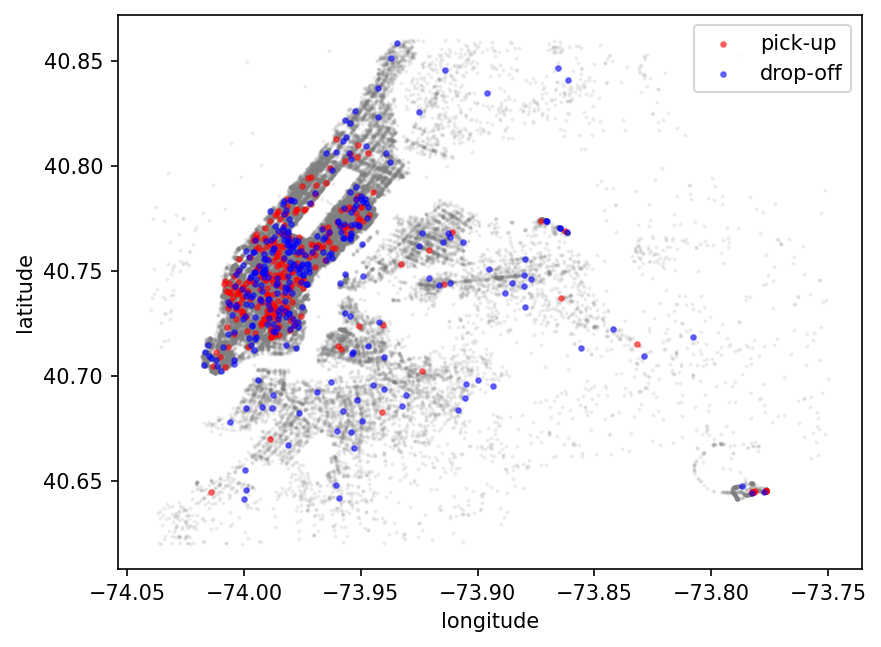

In [4]:
fig, ax = plt.subplots(dpi=150)
df_sampled = df.sample(frac=0.005, random_state=42)

plot(
    df["dropoff_loc_lon"],
    df["dropoff_loc_lat"],
    c="gray",
    s=1,
    alpha=0.1,
    ax=ax,
)
plot(
    df_sampled["pickup_loc_lon"],
    df_sampled["pickup_loc_lat"],
    label="pick-up",
    c="red",
    s=5,
    alpha=0.5,
    ax=ax,
)
plot(
    df_sampled["dropoff_loc_lon"],
    df_sampled["dropoff_loc_lat"],
    label="drop-off",
    c="blue",
    s=5,
    alpha=0.5,
    ax=ax,
)

### Fitting the underlying model

First, we split the dataset into 3 split: train, calibration and test.

In [5]:
random_state = 42
sampled_df = df.sample(n=10_000, random_state=random_state)
train_df, test_df = model_selection.train_test_split(
    sampled_df, test_size=0.2, random_state=random_state
)
train_df, calib_df = model_selection.train_test_split(
    train_df, test_size=0.2, random_state=random_state
)

X_train = train_df[["pickup_loc_lon", "pickup_loc_lat"]].to_numpy()
y_train = train_df[["dropoff_loc_lon", "dropoff_loc_lat"]].to_numpy()

X_calib = calib_df[["pickup_loc_lon", "pickup_loc_lat"]].to_numpy()
y_calib = calib_df[["dropoff_loc_lon", "dropoff_loc_lat"]].to_numpy()

X_test = test_df[["pickup_loc_lon", "pickup_loc_lat"]].to_numpy()
y_test = test_df[["dropoff_loc_lon", "dropoff_loc_lat"]].to_numpy()

Next, we fit the {mod}`sklearn` model and define a wrapper that can work with {func}`~jax.jit`, etc.

In [6]:
skl_model = neural_network.MLPRegressor(
    hidden_layer_sizes=(500,),
    learning_rate_init=0.0001,
    max_iter=2000,
    learning_rate="adaptive",
    random_state=42,
)

In [7]:
def model_fn(x: jnp.ndarray) -> jnp.ndarray:
    return jax.pure_callback(skl_model.predict, jnp.empty_like(x), x)


skl_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(500,), learning_rate='adaptive',
             learning_rate_init=0.0001, max_iter=2000, random_state=42)

## Fitting OTCP

The core of {class}`~ott.tools.conformal.OTCP` lies in learning a transport map that pushes non-conformity scores (computed on predictions vs. true labels) onto a reference measure, typically the uniform distribution on the unit ball. This transformation allows a meaningful ranking of multivariate scores using their norms in the transported space.

The {meth}`~ott.tools.conformal.OTCP.fit_transport` method fits this transport map. It takes the following key arguments:

- `x`: The input features used by the model to produce predictions.
- `y`: The true multivariate responses.
- `epsilon`: The entropic regularization parameter used in the Sinkhorn algorithm. A higher value of `epsilon` results in a smoother (but less accurate) transport map. This controls the trade-off between computational efficiency and the sharpness of the transport. In our experiments $\epsilon=0.1$ provided satisfactory results.
- `n_target`: The number of points used to discretize the target measure (e.g., the unit ball in $\mathbb{R}^d$). This choice affects the resolution of the approximation and by default, we use $8192$ points.

Internally, {meth}`~ott.tools.conformal.OTCP.fit_transport` computes the non-conformity scores between predictions and ground-truth, rescales them using empirical mean and maximum norm, and then aligns the empirical distribution with a spherical uniform measure using entropic optimal transport {cite}`cuturi:13`.

In [8]:
otcp = conformal.OTCP(model=model_fn)
otcp = otcp.fit_transport(jnp.array(X_train), jnp.array(y_train), epsilon=5e-2)

Once the transport is fit, {meth}`~ott.tools.conformal.OTCP.calibrate` computes the 1D scores needed for conformal prediction. It calls {meth}`~ott.tools.conformal.OTCP.get_scores`, which:
1. Evaluates the non-conformity scores (e.g., residuals),
2. Applies the rescaling and the transport,
3. Computes the $\ell_2$-norm in the target space.

These scores are stored and later used in the {meth}`~ott.tools.conformal.OTCP.predict` method to define a quantile threshold $q_{1-\alpha}$, which determines candidate predictions to be included in the conformal set.

In [9]:
otcp = otcp.calibrate(jnp.array(X_calib), jnp.array(y_calib))

## Backward Prediction

In the **backward** mode, {class}`~ott.tools.conformal.OTCP` constructs prediction sets by pulling back a high-probability region from the *target space* (typically the unit ball) through the inverse transport map.

Formally, the conformal set is:

$$
\mathcal{R}_\alpha(x) = \hat{y}(x) + T^{-1}(B(0, r_\alpha)),
$$

where:
- $B(0, r_\alpha)$ is a ball centered at 0 in the target space containing mass $1 - \alpha$,
- $T^{-1}$ is the inverse of the learned transport map,
- $\hat{y}(x)$ is the model's prediction at the given point $x$.

**Key idea**: in the target space, the distribution of transported scores is known (e.g., uniform), so we can easily construct a region with probability mass $1 - \alpha$. 
We then pull this region back to data space to obtain a valid conformal set around $\hat{y}(x)$. Since the transport map conserves the mass, it provides coverage guarantees in the source space.



In [10]:
test_idx, alpha = 0, 0.2

In [11]:
y_pred = skl_model.predict(X_test[test_idx, None]).squeeze(0)
y_pred.shape

(2,)

In [12]:
confidence_regions = otcp.predict(jnp.array(X_test[test_idx]), alpha=alpha)
confidence_regions.shape

(8191, 2)

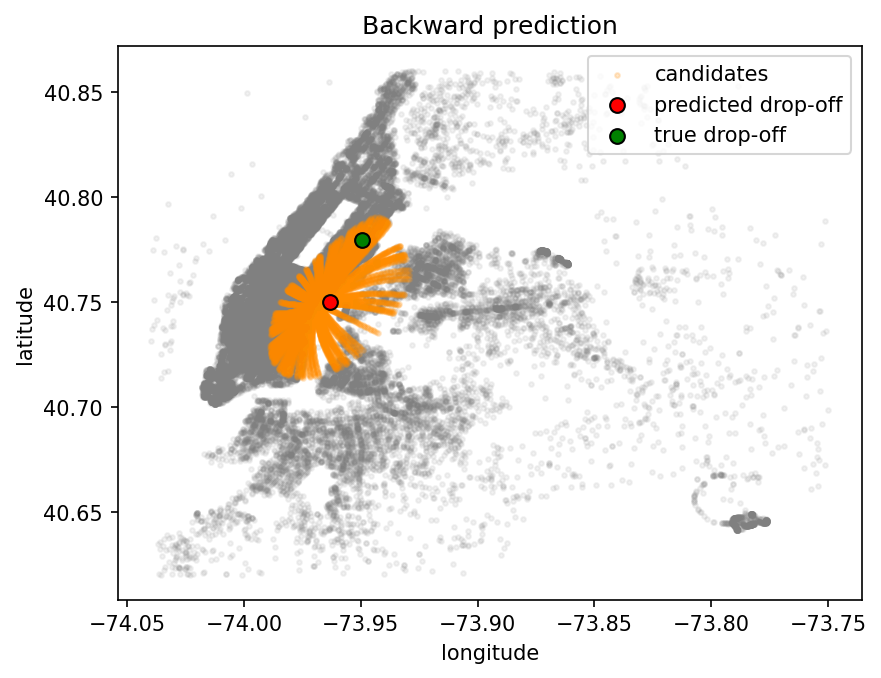

In [13]:
fig, ax = plt.subplots(dpi=150)
plot(
    df["dropoff_loc_lon"],
    df["dropoff_loc_lat"],
    c="gray",
    s=5,
    alpha=0.1,
    ax=ax,
)
plot(
    confidence_regions[:, 0],
    confidence_regions[:, 1],
    label="candidates",
    s=5,
    color="darkorange",
    alpha=0.2,
    ax=ax,
)
plot(
    y_pred[0],
    y_pred[1],
    s=50,
    label="predicted drop-off",
    c="red",
    ec="black",
    ax=ax,
)
plot(
    y_test[test_idx, 0],
    y_test[test_idx, 1],
    label="true drop-off",
    s=50,
    c="green",
    ec="black",
    ax=ax,
)
_ = ax.set_title("Backward prediction")

## Forward Prediction

In the **forward** mode, OTCP starts with a set of candidate predictions $y$ and filters those that belong to the conformal set.

The conformal set is:

$$
\mathcal{R}_\alpha(x) = \{ y : \|T(y - \hat{y}(x))\| \leq r_\alpha \},
$$

where:
- $T$ is the learned transport map,
- $\hat{y}(x)$ is the model's prediction,
- the radius $r_\alpha$ is the $(1 - \alpha)$ quantile of the calibration scores.

**Intuition**: each candidate is centered around the prediction, mapped into the target space, and tested for inclusion in the ball $B(0, r_\alpha)$ that holds probability mass $1 - \alpha$ in that space. This approach is efficient when you already have a discrete set of candidate outputs and want to select only those that are conformally valid.


In [14]:
y_candidates = jnp.vstack([y_train, y_calib])
mask = otcp.predict(
    jnp.array(X_test[test_idx]),
    y_candidates=y_candidates,
    alpha=alpha,
)
conformal_candidates = y_candidates[mask]
conformal_candidates.shape

(6442, 2)

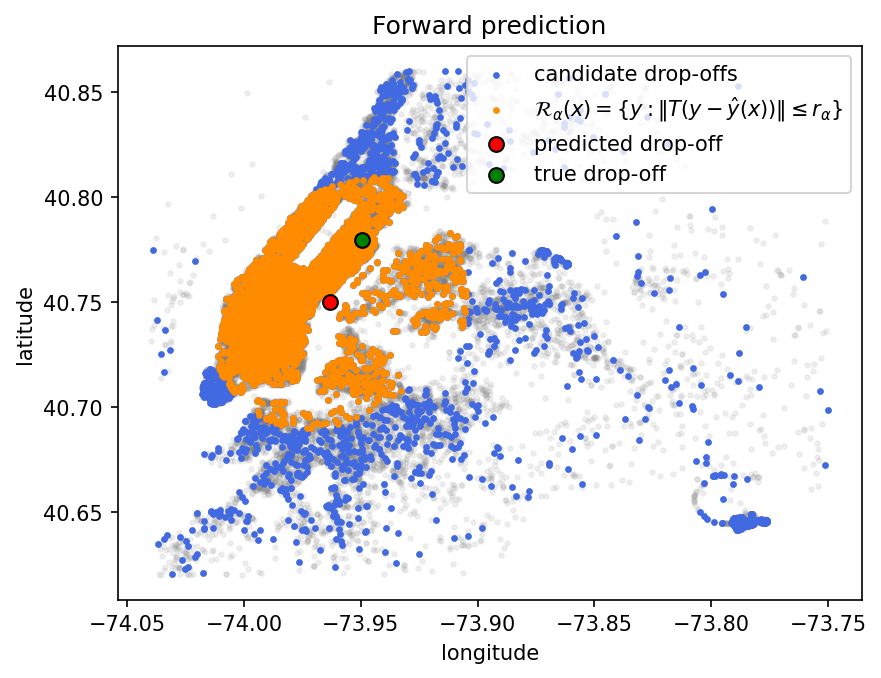

In [15]:
fig, ax = plt.subplots(dpi=150)
plot(
    df["dropoff_loc_lon"],
    df["dropoff_loc_lat"],
    s=5,
    c="gray",
    alpha=0.1,
    ax=ax,
)
plot(
    y_candidates[:, 0],
    y_candidates[:, 1],
    label="candidate drop-offs",
    s=5,
    c="royalblue",
    ax=ax,
)
plot(
    conformal_candidates[:, 0],
    conformal_candidates[:, 1],
    s=5,
    c="darkorange",
    label=r"$\mathcal{R}_\alpha(x) = \{ y : \|T(y - \hat{y}(x))\| \leq r_\alpha \}$",
    ax=ax,
)
plot(
    y_pred[0],
    y_pred[1],
    label="predicted drop-off",
    s=50,
    c="red",
    ec="black",
    ax=ax,
)
plot(
    y_test[test_idx, 0],
    y_test[test_idx, 1],
    label="true drop-off",
    s=50,
    c="green",
    ec="black",
    ax=ax,
)
_ = ax.set_title("Forward prediction")